# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [7]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random

ModuleNotFoundError: No module named 'seaborn'

In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement seaborn (from versions: none)
ERROR: No matching distribution found for seaborn


**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

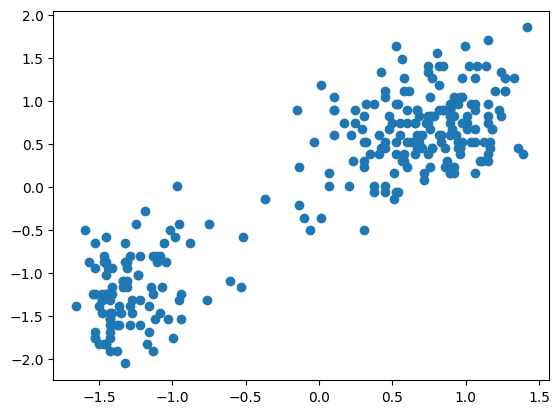

In [71]:
# Load the "Old Faithful" dataset from the Seaborn library
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']]
N, D = X. shape


# Standardize data to avoid numerical instabilities

# # # # # # # # #
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
# # # # # # # # #


# Show data

# # # # # # # # #
plt.scatter(X_scaled.iloc[:,0],X_scaled.iloc[:,1])
# # # # # # # # #


----- Votre réponse ici -----








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [167]:
def log_likelihood(X, mean, cov, pk): # Fill in the appropriate arguments

    # # # # # # # # #
    K = len(np.array(mean).shape)
    log_like = 0
    y = np.zeros((X.shape[0],K)).squeeze()
    # On distingue le cas multivariate normal du cas densité normal simple
    if K >1:
        for j in range(K):
            # On obtiens la densité du mix de gaussienne
            mvn = ss.multivariate_normal(mean= mean[j], cov=cov[j])
            # On évalue la pdf en X qu'on pondère avec pk
            y[:,j] = pk[j]*mvn.pdf(X)
            # On calcule la log likelihood
            log_like = np.sum(np.log(np.sum(y, axis = 1)))
    else:
        mvn = ss.multivariate_normal(mean= mean, cov=cov)
        y = pk*mvn.pdf(X)
        log_like = np.sum(np.log(y))
    
    return log_like
    # # # # # # # # #

In [168]:
# On test notre fonction log_likelihood en utilisant des paramètres aléatoires
k = 2
cov = [ np.eye(D) for _ in range (k)]
mean = [[random.uniform(-2, 2), random.uniform(-2, 2)] for _ in range(k)]
weights = [random.random() for _ in range(k)]
pk = [weights[j]/sum(weights) for j in range(k)]
log_likelihood(X_scaled, mean=mean, cov=cov, pk=pk)

-968.3292797550049

In [169]:
# On test le cas K = 1
cov = np.eye(D)
mean = [random.uniform(-2, 2), random.uniform(-2, 2)]

log_likelihood(X_scaled, mean=mean, cov=cov, pk=1)

-1318.5708101987284

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [170]:
def EM_algorithm_v1(X, K, Niter):
    N, D = X.shape
    # Initialize parameters

    # # # # # # # # #
    mean = X.iloc[:K].values
    cov = np.array([ np.eye(D) for _ in range (K)])
    pk = [1/K for i in range (K)]

    Log_vraisemblance = np.zeros(Niter)
    # # # # # # # # #

    for i in range(0,Niter):
        # E-STEP
        
        # # # # # # # # #
        rn = np.zeros((N,K))
        for j in range(K):
            mvn = ss.multivariate_normal(mean= mean[j], cov=cov[j])
            rn[:,j] = pk[j]*mvn.pdf(X)

        # tableau de taille NxK
        rn = np.array([rn[t]/np.sum(rn[t]) for t in range(N)])
        # # # # # # # # #
        
        # M-STEP
        
        # # # # # # # # #
        mean = np.dot(np.transpose(rn),X)/np.sum(rn, axis=0)[:, np.newaxis]
        
        for l in range(K):
            cov[l] = np.dot(np.transpose(rn[:,l][:, np.newaxis]*X),X)/np.sum(rn[:,l])
            cov[l] = cov[l] - mean[l][:, np.newaxis]*np.transpose(mean[l][:, np.newaxis])
        pk = np.mean(rn, axis=0)
        Log_vraisemblance[i] = log_likelihood(X, mean, cov, pk)
        # # # # # # # # #
    return Log_vraisemblance, mean, cov, pk 

**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

Text(0.5, 1.0, 'Évolution de la log-vraisemblance')

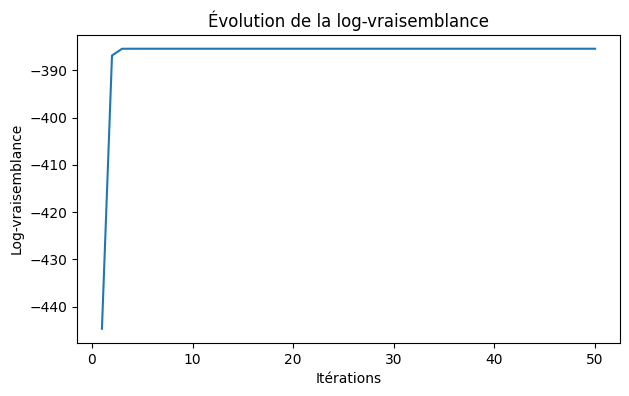

In [171]:
K = 2
Niter = 50

Log_vraisemblance, mean, cov, pk = EM_algorithm_v1(X_scaled, K, Niter)
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, Niter + 1), Log_vraisemblance)
plt.xlabel("Itérations")
plt.ylabel("Log-vraisemblance")
plt.title("Évolution de la log-vraisemblance")

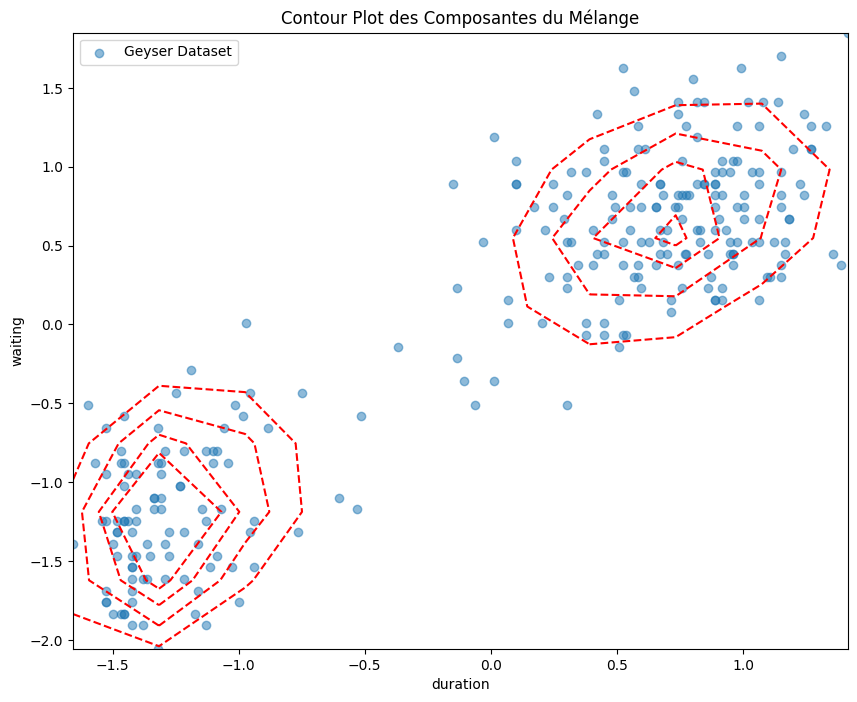

In [172]:

plt.figure(figsize=(10, 8))
plt.scatter(X_scaled.values[:, 0], X_scaled.values[:, 1], alpha=0.5, label="Geyser Dataset")

for j in range(K):
    mean_k = mean[j]
    cov_k = cov[j]
    # On génère un grid de point qui seront utilisés pour tracer les contours
    x, y = np.meshgrid(np.linspace(min(X_scaled.values[:, 0]), max(X_scaled.values[:, 0]), 10),
                   np.linspace(min(X_scaled.values[:, 1]), max(X_scaled.values[:, 1]), 10))

    pos = np.dstack((x, y))
    # On récupère la fonction de densité pour les paramètres de moyennes et de covariance estimé grace à l'algo EM
    rv = ss.multivariate_normal(mean=mean_k, cov=cov_k)
    # On plot les contours pour les levels 0.25, 0.5, 0.75 et 0.95
    plt.contour(x, y, rv.pdf(pos), levels=[0.25, 0.5, 0.75, 0.95], colors='r', linestyles='dashed')

plt.xlabel("duration")
plt.ylabel("waiting")
plt.title("Contour Plot des Composantes du Mélange")
plt.legend()
plt.show()


La Log-vraissemblance atteint très rapidement un plateau. Lorsqu'on visualise le mélange gaussien, on met effectivement en évidence la présence de 2 distributions distinctes qui semblent être de type gaussien.

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [173]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)
    # On initialise les moyennes à partir d'une distribution normal centrée-réduite
    mean = np.random.multivariate_normal(np.zeros(D), np.identity(D), size=K).squeeze()
    cov = np.array([ np.eye(D) for _ in range (K)]).squeeze()
    # On initialise les poids pk à partir d'une distribution de Dirichlet  
    pk = np.random.dirichlet(np.ones(K))

    Log_vrais = np.zeros(Niter)
    # # # # # # # # #

    for i in range(0,Niter):
        # E-STEP
        # # # # # # # # #
        rn = np.zeros((N,K))
        if K >1:
            for j in range(K):
                mvn = ss.multivariate_normal(mean= mean[j], cov=cov[j])
                rn[:,j] = pk[j]*mvn.pdf(X)
        else :
            mvn = ss.multivariate_normal(mean= mean, cov=cov)
            rn = pk*mvn.pdf(X)

        # tableau de taille NxK
        rn = np.array([rn[t]/np.sum(rn[t]) for t in range(N)])
        # # # # # # # # #
        
        # M-STEP
        
        # # # # # # # # #
        # on distingue le cas K=1 du cas multivarié
        if K >1:
            mean = np.dot(np.transpose(rn),X)/np.sum(rn, axis=0)[:, np.newaxis]
            for l in range(K):
                cov[l] = np.dot(np.transpose(rn[:,l][:, np.newaxis]*X),X)/np.sum(rn[:,l])
                cov[l] = cov[l] - mean[l][:, np.newaxis]*np.transpose(mean[l][:, np.newaxis])
        else: 
            mean = np.dot(np.transpose(rn),X)/np.sum(rn, axis=0) 
            cov = np.dot(np.transpose(rn[:, np.newaxis]*X),X)/np.sum(rn)
        
        pk = np.mean(rn, axis=0)


        Log_vrais[i] = log_likelihood(X, mean, cov, pk)
        # # # # # # # # #
    return Log_vrais, mean, cov, pk 

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

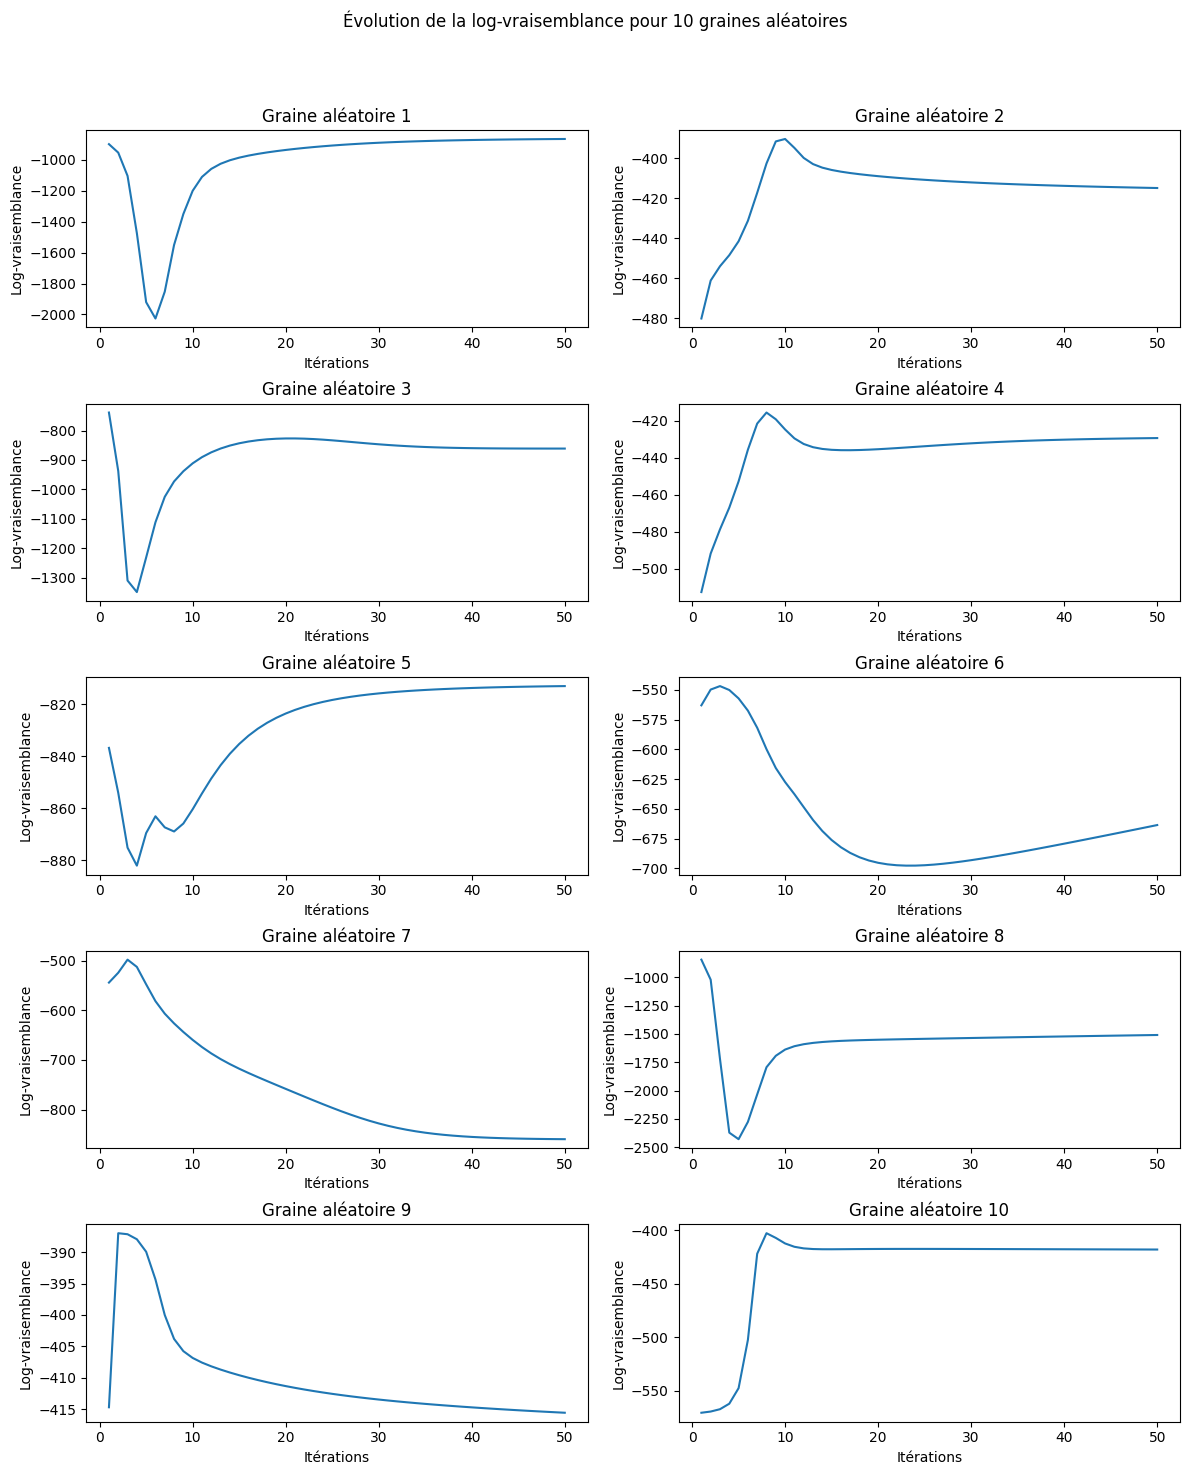

In [174]:
K = 3

Niter = 50
num_seed = 10

fig, axes = plt.subplots(5, 2, figsize=(12, 15))
fig.suptitle("Évolution de la log-vraisemblance pour 10 graines aléatoires")

# On plot la log vraissemblance pour 10 initilisations différentes
for n in range(num_seed):
    random_seed = n  

    log_vrais, _, _, _ = EM_algorithm_v2(X_scaled, K, Niter, random_seed)
    
    ax = axes[n // 2, n % 2]
    ax.plot(np.arange(1, Niter + 1), log_vrais)
    ax.set_xlabel("Itérations")
    ax.set_ylabel("Log-vraisemblance")
    ax.set_title(f"Graine aléatoire {n + 1}")


plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

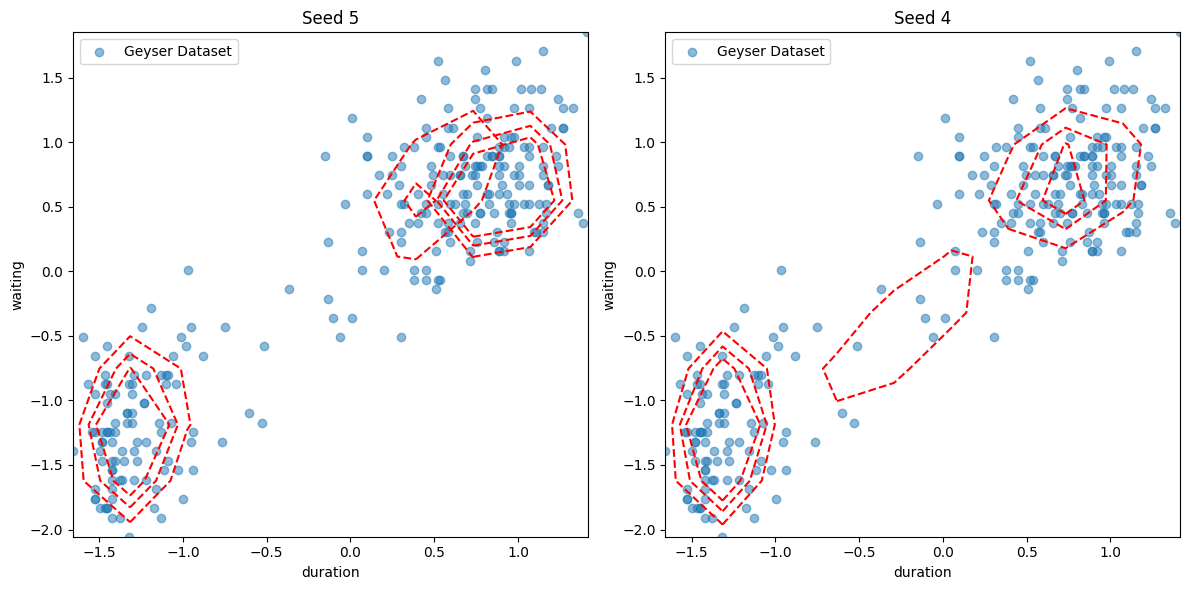

In [175]:
plt.figure(figsize=(12, 6)) 

ax1 = plt.subplot(1, 2, 1)  
ax2 = plt.subplot(1, 2, 2)  

# Affiche le premier tracé pour seed=5
ax1.scatter(X_scaled.values[:, 0], X_scaled.values[:, 1], alpha=0.5, label="Geyser Dataset")
log_vrais_5, mean_5, cov_5, pk_5 = EM_algorithm_v2(X_scaled, K, Niter, 5)

for j in range(K):
    mean_k_5 = mean_5[j]
    cov_k_5 = cov_5[j]
    x, y = np.meshgrid(np.linspace(min(X_scaled.values[:, 0]), max(X_scaled.values[:, 0]), 10),
                   np.linspace(min(X_scaled.values[:, 1]), max(X_scaled.values[:, 1]), 10))

    pos = np.dstack((x, y))
    rv = ss.multivariate_normal(mean=mean_k_5, cov=cov_k_5)
    ax1.contour(x, y, rv.pdf(pos), levels=[0.5, 0.75, 0.95], colors='r', linestyles='dashed')

ax1.set_xlabel("duration")
ax1.set_ylabel("waiting")
ax1.set_title("Seed 5")
ax1.legend()

# Affiche le deuxième tracé pour seed=4
ax2.scatter(X_scaled.values[:, 0], X_scaled.values[:, 1], alpha=0.5, label="Geyser Dataset")
log_vrais_4, mean_4, cov_4, pk_4 = EM_algorithm_v2(X_scaled, K, Niter, 4)

for j in range(K):
    mean_k_4 = mean_4[j]
    cov_k_4 = cov_4[j]
    x, y = np.meshgrid(np.linspace(min(X_scaled.values[:, 0]), max(X_scaled.values[:, 0]), 10),
                   np.linspace(min(X_scaled.values[:, 1]), max(X_scaled.values[:, 1]), 10))

    pos = np.dstack((x, y))
    rv = ss.multivariate_normal(mean=mean_k_4, cov=cov_k_4)
    ax2.contour(x, y, rv.pdf(pos), levels=[0.5, 0.75, 0.95], colors='r', linestyles='dashed')

ax2.set_xlabel("duration")
ax2.set_ylabel("waiting")
ax2.set_title("Seed 4")
ax2.legend()

plt.tight_layout() 
plt.show()




On observe que la log vraissemblance ne converge pas vers la même solutions selon l'initialisation des paramètres.
On doit chosir l'initialisation qui maximise la log vraissemblance, dans notre cas la random seed 4 nous donne un solution qui converge vers une log convergence de -420.

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance de le modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

In [179]:
BIC_values = []

for K in range(1,7):
    total_log_likelihood = 0

    log_vrais, _, _, _ = EM_algorithm_v2(X_scaled, K, Niter, 4)
    total_log_likelihood += log_vrais[-1]

    # Calcule du BIC pour un mix de K gaussiennes
    k_m = 0.5 * K * (D + 1) * (D + 2) - 1
    n = len(X_scaled)
    BIC = k_m * np.log(n) - 2 * total_log_likelihood
    BIC_values.append(BIC)

# On détermine l'indice du modèle optimal (plus petit BIC)
optimal_model_index = np.argmin(BIC_values)

print("BIC pour chaque modèle:", BIC_values)
print("Modèle optimal (K) selon le critère BIC, k =", optimal_model_index+1)

BIC pour chaque modèle: [1118.0159713267833, 832.5852139888145, 1721.2776578568219, 1780.39597660877, 3487.3443586919266, 3133.1473727647194]
Modèle optimal (K) selon le critère BIC, k = 2



On obtiens le résultat logique avec un mélange de 2 gaussiennes.

**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.


L'algorithme EM permet de faire du clustering en identifiant des groupes dont la densité se rapprochent d'une gaussienne. Ou du moins l'algorithme assimile les différents groupes à des distributions gaussiennes.